In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn import preprocessing

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
columns = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("data/kddcup.data.corrected", names=columns)

<IPython.core.display.Javascript object>

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


<IPython.core.display.Javascript object>

In [5]:
df.shape

(4898431, 42)

<IPython.core.display.Javascript object>

In [6]:
df = df[df.service == "http"].drop(columns=["service"], axis=1)
df = df[df["logged_in"] == 1]

<IPython.core.display.Javascript object>

In [7]:
df_2 = df.copy()

<IPython.core.display.Javascript object>

In [8]:
for column in df_2.columns:
    if df_2[column].dtype == "object":
        encoder = LabelEncoder()
        encoder.fit(df_2[column])
        df_2[column] = encoder.transform(df_2[column])

<IPython.core.display.Javascript object>

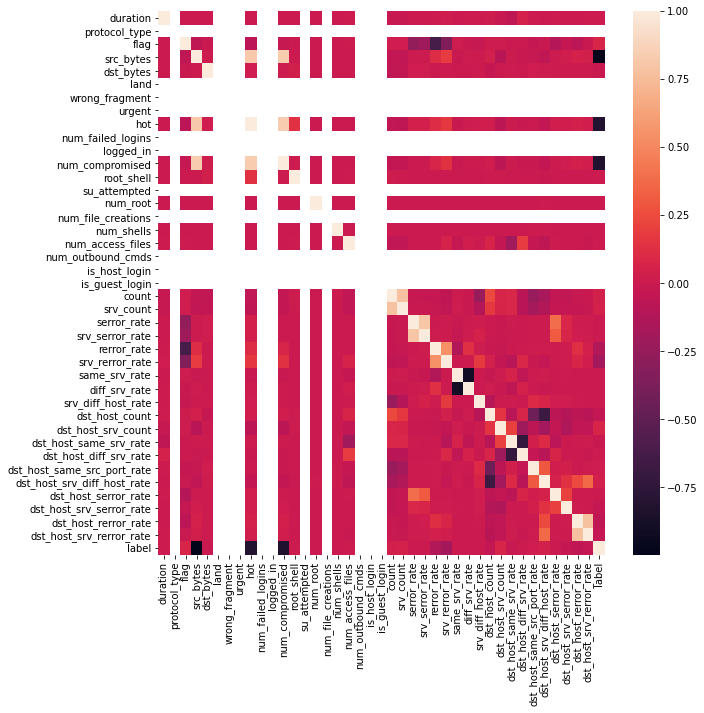

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))  # Sample figsize in inches

sns.heatmap(df_2.corr(), xticklabels=df_2.columns, yticklabels=df_2.columns, ax=ax)

plt.show()

## Model with only relevant future

### Data Preperation

In [10]:
relevant_features = ["duration", "src_bytes", "dst_bytes", "label"]

<IPython.core.display.Javascript object>

In [11]:
df_relevant = df[relevant_features]

<IPython.core.display.Javascript object>

In [12]:
df_relevant.loc[df_relevant["label"] == "normal.", "attack"] = 1
df_relevant.loc[df_relevant["label"] != "normal.", "attack"] = -1

target = df_relevant["attack"]

<IPython.core.display.Javascript object>

In [13]:
df_relevant = df_relevant.drop(columns=["label", "attack"], axis=1)

<IPython.core.display.Javascript object>

In [14]:
df_relevant.shape

(567498, 3)

<IPython.core.display.Javascript object>

In [15]:
target.shape

(567498,)

<IPython.core.display.Javascript object>

#### Normalize Data

In [16]:
X_normalized = preprocessing.normalize(df_relevant, norm="l2")

<IPython.core.display.Javascript object>

In [17]:
outliers = target[target == -1]

<IPython.core.display.Javascript object>

In [18]:
outliers.shape, target.shape

((2211,), (567498,))

<IPython.core.display.Javascript object>

In [19]:
print("Percentage of outliers in dataset:", (outliers.shape[0] / target.shape[0]) * 100)

Percentage of outliers in dataset: 0.38960489728598163


<IPython.core.display.Javascript object>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, target, stratify=target, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

### Model

In [21]:
nu = outliers.shape[0] / target.shape[0]

<IPython.core.display.Javascript object>

In [22]:
model = OneClassSVM(nu=nu, kernel="rbf", gamma=0.00005)

<IPython.core.display.Javascript object>

In [23]:
model.fit(X_train)

OneClassSVM(gamma=5e-05, nu=0.003896048972859816)

<IPython.core.display.Javascript object>

In [24]:
preds = model.predict(X_test)

<IPython.core.display.Javascript object>

In [25]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        -1.0       0.64      0.99      0.78       442
         1.0       1.00      1.00      1.00    113058

    accuracy                           1.00    113500
   macro avg       0.82      0.99      0.89    113500
weighted avg       1.00      1.00      1.00    113500



<IPython.core.display.Javascript object>

In [26]:
roc_auc_score(y_test, preds)

0.9921291550270639

<IPython.core.display.Javascript object>

In [27]:
cm = confusion_matrix(y_test, preds, labels=[-1, 1])

<IPython.core.display.Javascript object>

In [28]:
cm

array([[   436,      6],
       [   245, 112813]], dtype=int64)

<IPython.core.display.Javascript object>

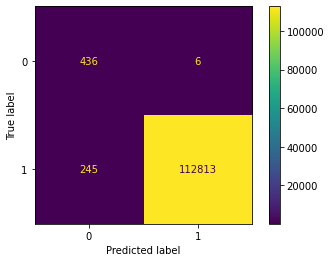

<IPython.core.display.Javascript object>

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp = disp.plot()

plt.show()